In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.dates import date2num, num2date
from utide import solve, reconstruct
import numpy as np
import pandas as pd
from windrose import WindroseAxes
import scipy as sp
import hvplot.xarray
from eofs.xarray import Eof
import glob
import sklearn as skl
from sklearn.utils.extmath import randomized_svd
#import dask
from matplotlib import style
import EOF_funcs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
import GA_cofine
from pyts.image import RecurrencePlot
from  importlib  import reload
import pywt
import utm

In [3]:
NWS=xr.open_dataset('Data/2021/NWS_focused.nc')
NK800=xr.open_dataset('Data/2021/NK800_focused.nc')

In [34]:
NK800

<xarray.Dataset>
Dimensions:      (time: 1464, Y: 305, X: 340)
Coordinates:
  * X            (X) float64 1.472e+05 1.48e+05 ... 4.176e+05 4.184e+05
  * Y            (Y) float64 3.344e+05 3.352e+05 ... 5.768e+05 5.776e+05
    depth        float64 0.0
  * time         (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
    lat          (Y, X) float64 58.43 58.43 58.44 58.45 ... 61.53 61.54 61.55
    lon          (Y, X) float64 5.453 5.459 5.465 5.47 ... 3.489 3.495 3.501
Data variables:
    u_eastward   (time, Y, X) float32 nan nan nan nan nan ... nan nan nan nan
    v_northward  (time, Y, X) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/33)
    file:                            /home/metno_op/run/norkyst-800m_2017/oce...
    type:                            ROMS/TOMS history file
    title:                           NorKyst-800m - ROMS
    var_info:                        /home/metno_op/sea/ROMS/metroms/apps/com...
    rst_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    his_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    ...                              ...
    history:                         Tue Jun  1 17:15:38 2021: ncks -O --4 -d...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     NORKYST800M, ADD_FSOBC, ADD_M2OBC, ALBED...
    Conventions:                     CF-1.4, SGRID-0.3
    NCO:                             netCDF Operators version 4.8.0 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [4]:
NKs=NK800.stack(z=['Y','X'])
NWSs=NWS.stack(z=['lat','lon'])

In [5]:
NWSs

<xarray.Dataset>
Dimensions:  (time: 1464, z: 14406)
Coordinates:
    depth    float32 ...
  * time     (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
  * z        (z) MultiIndex
  - lat      (z) float64 59.01 59.01 59.01 59.01 ... 60.99 60.99 60.99 60.99
  - lon      (z) float64 3.03 3.061 3.091 3.121 3.152 ... 5.879 5.909 5.939 5.97
Data variables:
    vo       (time, z) float32 -0.028 0.001 0.065 0.143 ... nan nan nan nan
    uo       (time, z) float32 0.031 0.008 0.011 0.024 0.027 ... nan nan nan nan
Attributes: (12/15)
    title:                hourly-instantaneous horizontal velocity (3D)
    Conventions:          CF-1.7
    source:               PS-OS 45, AMM-FOAM 1.5 km (tidal) NEMO v3.6_WAVEWAT...
    contact:              servicedesk.cmems@mercator-ocean.eu
    netcdf-version-id:    netCDF-4
    references:           http://marine.copernicus.eu/
    ...                   ...
    forcing_data_source:  ECMWF Global Atmospheric Model (HRES); CMEMS-MERCAT...
    product:              NORTHWESTSHELF_ANALYSIS_FORECAST_PHY_004_013
    credit:               E.U. Copernicus Marine Service Information (CMEMS)
    licence:              http://marine.copernicus.eu/services-portfolio/serv...
    _CoordSysBuilder:     ucar.nc2.dataset.conv.CF1Convention
    comment:

In [9]:
grid_x, grid_y = np.meshgrid(NWSs.lon.data, NWSs.lat.data)


In [11]:
np.shape((grid_x,grid_y))

(2, 14406, 14406)

In [16]:
NK800.u_eastward

<xarray.DataArray 'u_eastward' (time: 1464, Y: 305, X: 340)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * X        (X) float64 1.472e+05 1.48e+05 1.488e+05 ... 4.176e+05 4.184e+05
  * Y        (Y) float64 3.344e+05 3.352e+05 3.36e+05 ... 5.768e+05 5.776e+05
    depth    float64 ...
  * time     (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
    lat      (Y, X) float64 58.43 58.43 58.44 58.45 ... 61.53 61.53 61.54 61.55
    lon      (Y, X) float64 5.453 5.459 5.465 5.47 ... 3.483 3.489 3.495 3.501
Attributes:
    long_name:      eastward momentum component at RHO-points
    units:          meter second-1
    time:           ocean_time
    standard_name:  eastward_sea_water_velocity
    grid:           grid
    location:       face
    field:          u_eastward, scalar, series
    grid_mapping:   projection_stere
    _ChunkSizes:    [   1    1   17 2602]

In [15]:
np.shape((NK800.lat,NK800.lon))

(2, 305, 340)

In [18]:
tmp=sp.interpolate.griddata((NKs.lon.data,NKs.lat.data),NKs.u_eastward.mean(dim='time').data,(grid_x,grid_y))

In [19]:
np.shape(tmp)

(14406, 14406)

In [33]:
NKs.dropna(dim='z',how='all').unstack()

<xarray.Dataset>
Dimensions:      (time: 1464, Y: 305, X: 311)
Coordinates:
    depth        float64 0.0
  * time         (time) datetime64[ns] 2021-06-01 ... 2021-07-31T23:00:00
    lat          (Y, X) float64 59.01 59.01 nan nan nan ... nan nan nan nan nan
    lon          (Y, X) float64 5.989 5.995 nan nan nan ... nan nan nan nan nan
  * Y            (Y) float64 3.344e+05 3.352e+05 ... 5.768e+05 5.776e+05
  * X            (X) float64 2.192e+05 2.2e+05 2.184e+05 ... 1.48e+05 1.472e+05
Data variables:
    u_eastward   (time, Y, X) float32 -0.1041 -0.155 nan nan ... nan nan nan nan
    v_northward  (time, Y, X) float32 0.009011 -0.01266 nan nan ... nan nan nan
Attributes: (12/33)
    file:                            /home/metno_op/run/norkyst-800m_2017/oce...
    type:                            ROMS/TOMS history file
    title:                           NorKyst-800m - ROMS
    var_info:                        /home/metno_op/sea/ROMS/metroms/apps/com...
    rst_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    his_file:                        /home/metno_op/run/norkyst-800m_2017/oce...
    ...                              ...
    history:                         Tue Jun  1 17:15:38 2021: ncks -O --4 -d...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     NORKYST800M, ADD_FSOBC, ADD_M2OBC, ALBED...
    Conventions:                     CF-1.4, SGRID-0.3
    NCO:                             netCDF Operators version 4.8.0 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

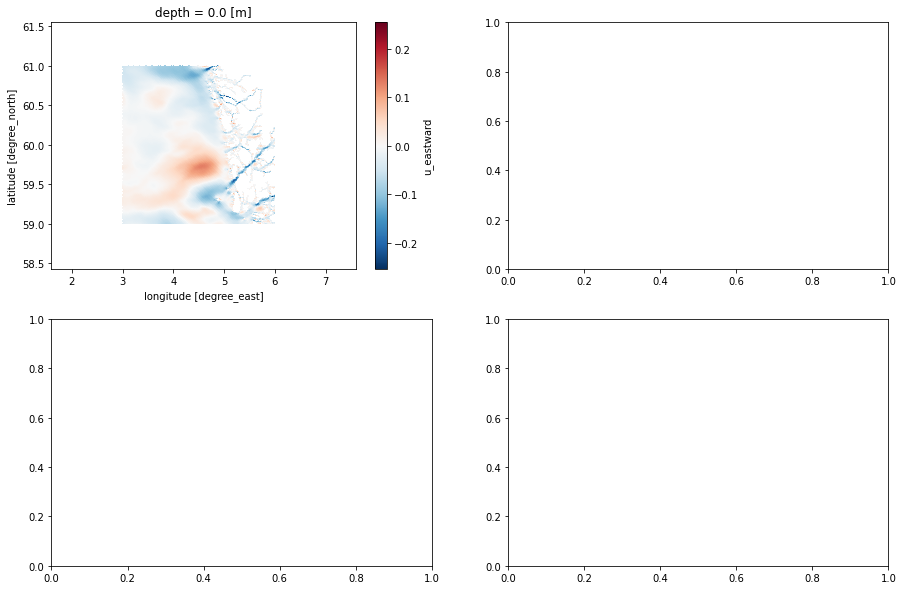

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
NKs.u_eastward.mean(dim='time').unstack('z').plot(x='lon',y='lat',ax=axes[0,0])